In [18]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

## Loading the Dataset

In [19]:
#looking at the preprocessed data
df = pd.read_csv("cleaned_dataset.csv")
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


## Splitting the dataset into trainning and test

In [20]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

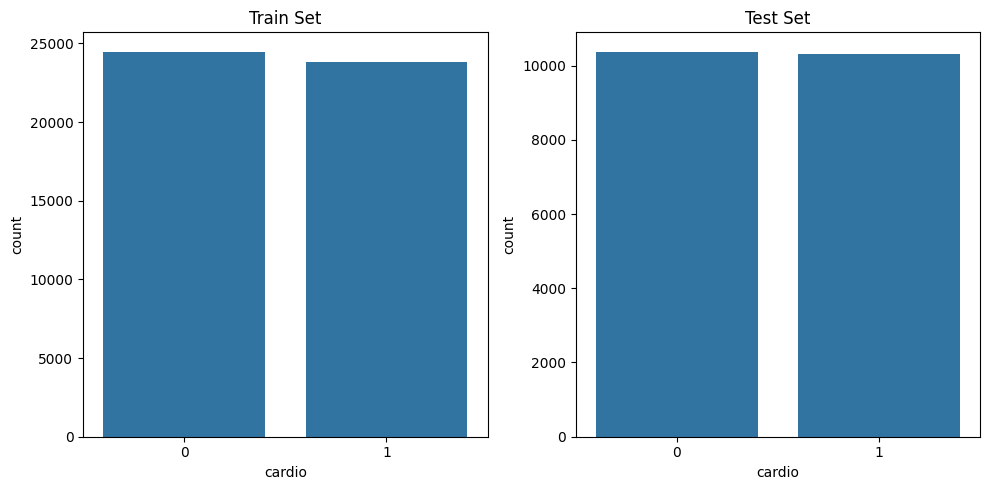

In [21]:
#looking at the counts for training and test dataset
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Train Set")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test Set")
plt.tight_layout()

## Choosing the best neural network architecture

Hyperparameter tuning is performed below on several parameters of the neural network such as number of units in any layer, activation functions, dropout rate, optimizer choice and learning rate. For simplicity, we will tune the number of hidden layers separately.

### Network with one hidden layer

In [22]:
#building neural network with one hidden layer and performing hyperparameter tuning
def single_layer_model(hp):
    model = Sequential()
    
    # Input Layer with fixed unit choices
    model.add(Dense(hp.Choice('units', [256, 512, 1024, 2048])))

    # Activation function selection
    activation_choice = hp.Choice('activation', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout', values=[0.1, 0.2, 0.3])))  

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]) 

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )
    return model

In [23]:
# Initialize Keras Tuner with Hyperband
tuner = kt.Hyperband(
    single_layer_model,
    objective=['val_recall','val_precision'],  
    max_epochs=20,           
    factor=4,
    directory='One hidden layer',
    project_name='disease_classification_fast')

In [24]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',         # Stop training if recall doesn't improve
#     patience=4,                   # Wait for 4 epochs before stopping
#     restore_best_weights=True     # Restore best model
# )

# Performing hyperparameter search
tuner.search(
    X_train, y_train, 
    epochs=20,  
    validation_data=(X_test, y_test),
    batch_size=64,
    #callbacks=[early_stopping],  # Use Early Stopping
    verbose=1
)

Trial 44 Complete [00h 00m 32s]
multi_objective: -1.4554035067558289

Best multi_objective So Far: -1.5089197158813477
Total elapsed time: 00h 11m 41s


In [25]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Layer 1 Units: {best_hps.get('units')}
- Layer 1 Activation: {best_hps.get('activation')}
- Layer 1 Dropout: {best_hps.get('dropout')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Layer 1 Units: 2048
- Layer 1 Activation: leaky_relu
- Layer 1 Dropout: 0.3
- Optimizer: rmsprop
- Learning Rate: 0.1



In [26]:
# Build and train the best model using the best batch size from hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.5319 - precision_3: 0.5972 - recall_3: 0.6042 - val_loss: 4.4502 - val_precision_3: 0.5478 - val_recall_3: 0.9292
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.5139 - precision_3: 0.6033 - recall_3: 0.6064 - val_loss: 4.2301 - val_precision_3: 0.6263 - val_recall_3: 0.5253
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7894 - precision_3: 0.5992 - recall_3: 0.6004 - val_loss: 3.4305 - val_precision_3: 0.6064 - val_recall_3: 0.5225
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.5172 - precision_3: 0.6071 - recall_3: 0.6051 - val_loss: 6.5250 - val_precision_3: 0.8346 - val_recall_3: 0.3881
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.6301 - precision_3: 0.6034 - recall_3: 0.5980 - val_loss: 3.6663 - val_precision_3: 0.8057 - val_recall_3: 0.5096
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.6171 - precision_3: 0.6052 - recall_3: 0.6034 

In [27]:
#predicting on X_test using the best model
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [28]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,9330,1047
Actual 1,6140,4183


In [29]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 65.28%
Precision: 79.98%
Recall: 40.52%
F1_score: 53.79%


### Network with two hidden layer

In [30]:
#building neural network with two hidden layer and performing hyperparameter tuning
def two_layer_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Choice('units_1', [128,256,512])))

    # Activation function selection
    activation_choice = hp.Choice('activation_1', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])))  

    model.add(Dense(hp.Choice('units_2', [64,128,256])))

    # Activation function selection
    activation_choice = hp.Choice('activation_2', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3])))

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3]) 

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )

    return model

In [31]:
# Initialize Keras Tuner with Hyperband, lowering max_epochs to 20 and factor to 3
tuner = kt.Hyperband(
    two_layer_model,
    objective=['val_recall','val_precision'],  # Optimize for recall
    max_epochs= 20,           # Reduced maximum epochs
    factor=4,
    directory='Two hidden layer',
    project_name='disease_classification_fast')

In [32]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',  # Stop training if recall doesn't improve
#     patience=4,            # Wait for 4 epochs before stopping
#     restore_best_weights=True  # Restore best model
# )

# Perform hyperparameter search using a fixed batch size (e.g., 32) during the search phase with verbose off
tuner.search(X_train, y_train, 
             epochs=20,  # Reduced number of epochs
             validation_data=(X_test, y_test),
             batch_size=32,
             #callbacks=[early_stopping],  # Use Early Stopping
             verbose=1,
)

Trial 44 Complete [00h 01m 31s]
multi_objective: -1.5081620812416077

Best multi_objective So Far: -1.5120445489883423
Total elapsed time: 00h 31m 34s


In [33]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Layer 1 Units: {best_hps.get('units_1')}
- Layer 1 Activation: {best_hps.get('activation_1')}
- Layer 1 Dropout: {best_hps.get('dropout_1')}
- Layer 2 Units: {best_hps.get('units_2')}
- Layer 2 Activation: {best_hps.get(f'activation_2')}
- Layer 2 Dropout: {best_hps.get('dropout_2')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Layer 1 Units: 128
- Layer 1 Activation: leaky_relu
- Layer 1 Dropout: 0.3
- Layer 2 Units: 128
- Layer 2 Activation: relu
- Layer 2 Dropout: 0.2
- Optimizer: rmsprop
- Learning Rate: 0.1



In [34]:
# Build and train the best model using the best batch size from hyperparameters with verbose off
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.0526 - precision_3: 0.5476 - recall_3: 0.4310 - val_loss: 0.6970 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7025 - precision_3: 0.4908 - recall_3: 0.3889 - val_loss: 0.6949 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7245 - precision_3: 0.4964 - recall_3: 0.4027 - val_loss: 0.6958 - val_precision_3: 0.4987 - val_recall_3: 1.0000
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7592 - precision_3: 0.4935 - recall_3: 0.4428 - val_loss: 0.6962 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7007 - precision_3: 0.4947 - recall_3: 0.4353 - val_loss: 0.6933 - val_precision_3: 0.4987 - val_recall_3: 1.0000
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6995 - precision_3: 0.

In [35]:
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [36]:
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,10377,0
Actual 1,10323,0


In [37]:
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 50.13%
Precision: 0.00%
Recall: 0.00%
F1_score: 0.00%


c:\Users\Shivam\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Network with three hidden layer

In [38]:
# Define model-building function for Keras Tuner with reduced search space
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Choice('units_1', [128,256,512])))

    # Activation function selection
    activation_choice = hp.Choice('activation_1', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])))  

    model.add(Dense(hp.Choice('units_2', [64,128,256])))

    # Activation function selection
    activation_choice = hp.Choice('activation_2', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3])))

    model.add(Dense(hp.Choice('units_3', [32, 64, 128])))

    # Activation function selection
    activation_choice = hp.Choice('activation_3', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_3', values=[0.1, 0.2, 0.3])))

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])  # Added another value for tuning

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )

    return model

In [39]:
# Initialize Keras Tuner with Hyperband, lowering max_epochs to 20 and factor to 3
tuner = kt.Hyperband(
    build_model,
    objective=['val_recall','val_precision'],  # Optimize for recall
    max_epochs=20,           # Reduced maximum epochs
    factor=4,
    directory='Three hidden layer',
    project_name='disease_classification_fast')

In [40]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',  # Stop training if recall doesn't improve
#     patience=4,            # Wait for 4 epochs before stopping
#     restore_best_weights=True  # Restore best model
# )

# Perform hyperparameter search using a fixed batch size (e.g., 32) during the search phase with verbose off
tuner.search(X_train, y_train, 
             epochs=20,  # Reduced number of epochs
             validation_data=(X_test, y_test),
             batch_size=32,
             #callbacks=[early_stopping],  # Use Early Stopping
             verbose=1,
)

Trial 33 Complete [00h 00m 21s]
multi_objective: -1.4699949622154236

Best multi_objective So Far: -1.4986956417560577
Total elapsed time: 00h 09m 46s

Search: Running Trial #34

Value             |Best Value So Far |Hyperparameter
512               |128               |units_1
relu              |leaky_relu        |activation_1
0.3               |0.3               |dropout_1
64                |64                |units_2
relu              |leaky_relu        |activation_2
0.1               |0.3               |dropout_2
64                |32                |units_3
relu              |relu              |activation_3
0.1               |0.1               |dropout_3
adam              |adam              |optimizer
0.01              |0.1               |learning_rate
5                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/5
1510/1510 ━

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Layer 1 Units: {best_hps.get('units_1')}
- Layer 1 Activation: {best_hps.get('activation_1')}
- Layer 1 Dropout: {best_hps.get('dropout_1')}
- Layer 2 Units: {best_hps.get('units_2')}
- Layer 2 Activation: {best_hps.get(f'activation_2')}
- Layer 2 Dropout: {best_hps.get('dropout_2')}
- Layer 3 Units: {best_hps.get('units_3')}
- Layer 3 Activation: {best_hps.get(f'activation_3')}
- Layer 3 Dropout: {best_hps.get('dropout_3')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

In [ ]:
# Build and train the best model using the best batch size from hyperparameters with verbose off
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

In [ ]:
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [ ]:
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")